convert() was used to fix some broken geometries not supported by Fusion Table and Google Earth Enging.

- Convert HydroBASIN polygons from SHP to KML
- Fix geometry errors 
- Simplify geometry (optionally)

In [1]:
%matplotlib inline

import logging
import sys
import os
import glob

import math
import ogr
import shapely.geometry, shapely.wkt
import pylab
import matplotlib.pyplot as plt
from utils.shapely_plot import draw
import shapely as sl
import fiona
import numpy as np

pylab.rcParams['figure.figsize'] = (17.0, 15.0)
logging.basicConfig(stream=sys.stderr, level=logging.INFO)


/usr/lib/python2.7/dist-packages/pkg_resources/__init__.py:1224: UserWarning: /home/gennadiy_donchyts/.python-eggs is writable by group/others and vulnerable to attack when used with get_resource_filename. Consider a more secure location (set with .set_extraction_path or the PYTHON_EGG_CACHE environment variable).
  warnings.warn(msg, UserWarning)


In [2]:
def convert(input_path):
    output_path = os.path.splitext(input_path)[0] + '.kml'

    filename = os.path.splitext(os.path.basename(input_path))[0]

    dst_ds = ogr.GetDriverByName('KML').CreateDataSource(output_path)
    dst_lyr = dst_ds.CreateLayer(filename)

    # create fields using OGR
    src_ds = ogr.Open(input_path)
    src_lyr = src_ds.GetLayerByIndex(0)
    f = src_lyr.GetFeature(0)
    [dst_lyr.CreateField(f.GetFieldDefnRef(i)) for i in range(f.GetFieldCount())]

    for feat in src_lyr:
        try:
            geom = shapely.wkt.loads(feat.GetGeometryRef().ExportToWkt())
        except Exception as e: 
            print('Error({0}), skipping geometry.'.format(e))
            continue

        #id = feat.GetField('HYBAS_ID')
        count = get_geom_coord_count(geom)

        # geom coord count
        # print('{0}: {1}'.format(id, count))

        if count > 10000:
            print ('simplifying ...')
            geom = geom.simplify(0.004)
        
        # uncomment in case of messed-up geometry
        #
        if not geom.is_valid:
            geom = geom.buffer(0.0)

        # geom = geom.simplify(0.004)

        # if id == 6030021870:
        #    print ('simplifying ...')
        #    geom = geom.simplify(0.004)

        f = ogr.Feature(dst_lyr.GetLayerDefn())

        # set field values
        for i in range(feat.GetFieldCount()):
            fd = feat.GetFieldDefnRef(i)
            f.SetField(fd.GetName(), feat.GetField(fd.GetName()))

        # set geometry    
        f.SetGeometry(ogr.CreateGeometryFromWkt(geom.to_wkt()))
        
        # create feature
        dst_lyr.CreateFeature(f)
        
        f.Destroy() 
        
    src_ds.Destroy()

    dst_ds.Destroy()

# files = glob.glob(r'D:\gis\HydroBASINS\without_lakes\hybas_sa_lev*_v1c.shp')
# files = glob.glob(r'D:\gis\HydroBASINS\without_lakes\simplified\hybas_au_lev08_v1c.shp')

# files = glob.glob(r'D:\gis\GRanD\GRanD_dams_v1_1.shp')
files = glob.glob(r'D:\gis\GRanD\GRanD_reservoirs_v1_1.shp')

# files = glob.glob(r'D:\gis\HydroBASINS\rivers\*_riv_15s.shp')
# files = [r'D:\gis\OpenStreetMaps\Asia\Australia\rivers_lines.shp',
#          r'D:\gis\OpenStreetMaps\Asia\Australia\rivers_multipolygons.shp']

# files = [r'D:\gis\OpenStreetMaps\simplified-land-polygons-complete-3857\simplified_land_polygons.shp']
    
# convert(r'D:\src\GitHub\data-utils\notebooks\shapefile.shp')

# convert(r'D:\gis\HydroBASINS\without_lakes\hybas_au_lev07_v1c.shp')

for f in files:
    convert(f)


In [ ]:
import fiona

c = fiona.collection(files[0], "r")
print(c.schema)

type_map = { 'float' : ogr.OFTReal, 'int' : ogr.OFTInteger }

fields = c.schema['properties']
for p in fields:
    print p + ' ' + fields[p]

C:\Anaconda\lib\site-packages\numba\dataflow.py:52: RuntimeWarning: inconsistent stack offset for block(offset:326, outgoing: [], incoming: [21, 61, 110, 323])
  RuntimeWarning)


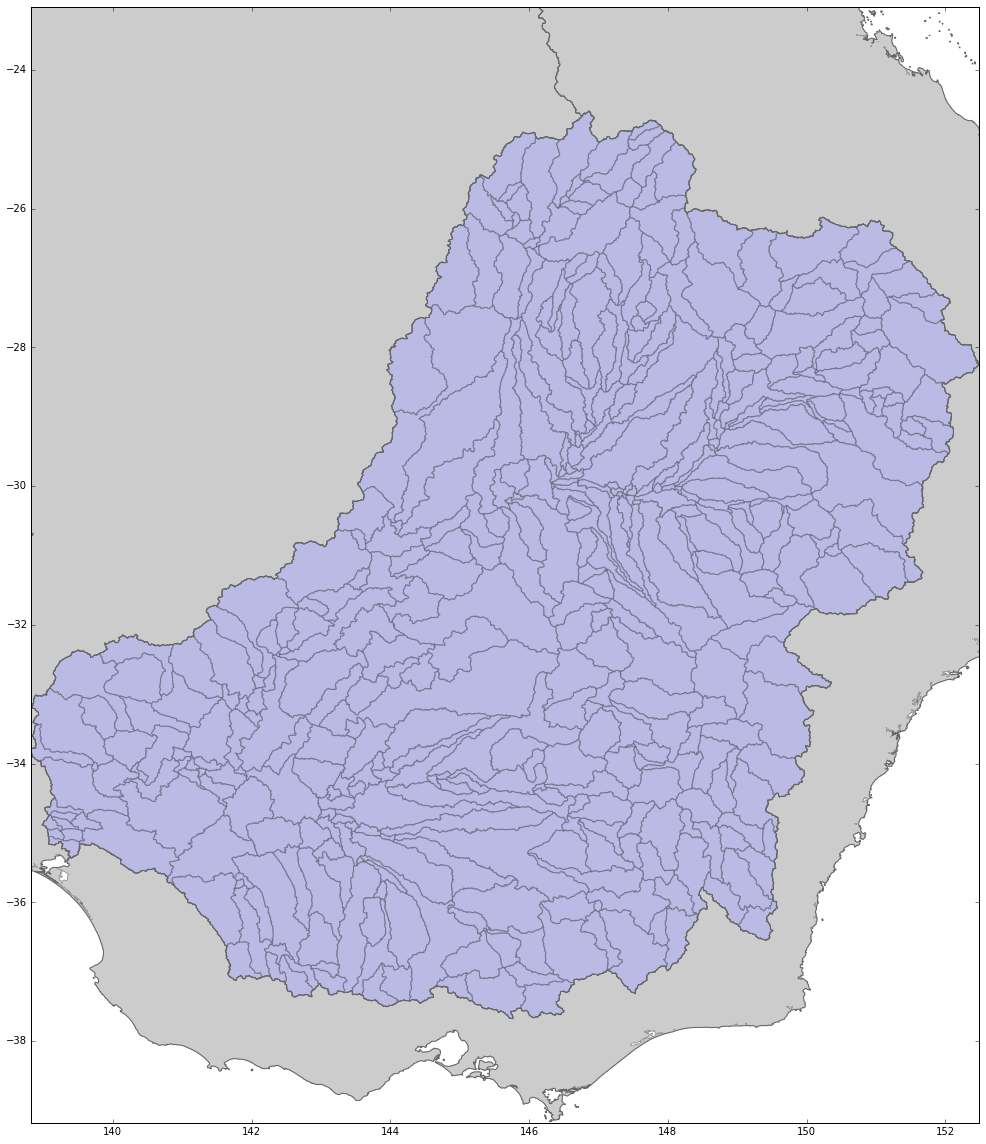

In [3]:
# Select sub-basins that fall within a larger basin and then group them by using a regular grid

# Amazon
# main_basin_shp = 'D:\gis\HydroBASINS\without_lakes\hybas_sa_lev02_v1c.shp'
# main_basin_id = 6020006540
# sub_basin_shp = 'D:\gis\HydroBASINS\without_lakes\hybas_sa_lev06_v1c.shp'

# Murray & Darling
main_basin_shp = 'D:\gis\HydroBASINS\without_lakes\hybas_au_lev03_v1c.shp'
main_basin_id = 5030073410
sub_basin_shp = 'D:\gis\HydroBASINS\without_lakes\hybas_au_lev07_v1c.shp'

pylab.rcParams['figure.figsize'] = (17.0, 20.0)

fig = plt.figure()
axes = plt.axes()
axes.set_aspect('equal', 'datalim')

main_basin_geom = None

with fiona.collection(main_basin_shp, "r") as input:
    for f in input:
        geom = sl.geometry.shape(f['geometry'])

        id = f['properties']['HYBAS_ID']
        if id == main_basin_id:
            main_basin_geom = geom
        draw(geom)

bounds = main_basin_geom.bounds
axes.set_xlim(bounds[0], bounds[2])
axes.set_ylim(bounds[1], bounds[3])
                                
with fiona.collection(sub_basin_shp, "r") as input:
    for f in input:
        geom = sl.geometry.shape(f['geometry'])

        if main_basin_geom.contains(geom):
            
            
        else:
            pass
            # draw(geom, fill='#ffffff', lw=0.1)

plt.show()  


In [7]:
def get_basin(id, path):
    with fiona.collection(path, "r") as input:
        for f in input:
            id = f['properties']['HYBAS_ID']
            if id == main_basin_id:
                return f
    return None

def get_child_basins(parent_pfaf_id, child_basins_path):
    with fiona.collection(child_basins_path, "r") as input:
        for feature in input:
            pfaf_id = feature['properties']['PFAF_ID'] 
            if str(pfaf_id).startswith(str(parent_pfaf_id)): 
                yield feature

# Amazon
# files = glob.glob(r'D:\gis\HydroBASINS\without_lakes\hybas_sa_lev*_v1c.shp')[1:]
# main_basin_id = 6020006540
# start = 0

files = glob.glob(r'D:\gis\HydroBASINS\without_lakes\hybas_au_lev*_v1c.shp')[1:]
main_basin_id = 5030073410
start = 2

main_basin = get_basin(main_basin_id, files[start])

pfaf_id = str(main_basin['properties']['PFAF_ID'])
main_basin_geom = sl.geometry.shape(main_basin['geometry'])

print('Main basin: ' + files[0])
print('Area: ' + str(main_basin_geom.area))

total_count = 0

def get_children(main_basin_id, child_basins_path):
    print('Child basins: ' + child_basins_path)
    child_basins = list(get_child_basins(main_basin_id, child_basins_path))
    child_basins_ids = [str(f['properties']['PFAF_ID']) for f in child_basins]
    child_basins_geoms = [sl.geometry.shape(f['geometry']) for f in child_basins]
    count = len(child_basins)
    global total_count
    total_count += count
    print(count)
    
    return (child_basins, child_basins_ids, child_basins_geoms)

basins3, ids3, geoms3 = get_children(pfaf_id, files[start + 1])
basins4, ids4, geoms4 = get_children(pfaf_id, files[start + 2])
basins5, ids5, geoms5 = get_children(pfaf_id, files[start + 3])
basins6, ids6, geoms6 = get_children(pfaf_id, files[start + 4])
basins7, ids7, geoms7 = get_children(pfaf_id, files[start + 5])
basins8, ids8, geoms8 = get_children(pfaf_id, files[start + 6])

basins_per_level = [basins3, basins4, basins5, basins6, basins7, basins8]

print('Total basins: ' + str(total_count))

Main basin: D:\gis\HydroBASINS\without_lakes\hybas_au_lev01_v1c.shp
Area: 100.489618539
Child basins: D:\gis\HydroBASINS\without_lakes\hybas_au_lev04_v1c.shp
10
Child basins: D:\gis\HydroBASINS\without_lakes\hybas_au_lev05_v1c.shp
27
Child basins: D:\gis\HydroBASINS\without_lakes\hybas_au_lev06_v1c.shp
137
Child basins: D:\gis\HydroBASINS\without_lakes\hybas_au_lev07_v1c.shp
434
Child basins: D:\gis\HydroBASINS\without_lakes\hybas_au_lev08_v1c.shp
1439
Child basins: D:\gis\HydroBASINS\without_lakes\hybas_au_lev09_v1c.shp
3809
Total basins: 5856


Put all catchments into a graph

In [8]:
import networkx as nx
n = nx.DiGraph()

ids = [pfaf_id]+ids3+ids4+ids5+ids6+ids7
areas = [g.area for g in [main_basin_geom]+geoms3+geoms4+geoms5+geoms6+geoms7]
basins = [b for b in [main_basin]+basins3+basins4+basins5+basins6+basins7]

n.add_nodes_from([(i,{'area':a, 'feature':f}) for (i,a,f) in zip(ids, areas, basins)])
# n.add_nodes_from([(i,{'area':a}) for (i,a,f) in zip(ids, areas, basins)])

n.add_edges_from([(pfaf_id, i) for i in ids3])
n.add_edges_from([(i[:-1], i) for i in ids4])
n.add_edges_from([(i[:-1], i) for i in ids5])
n.add_edges_from([(i[:-1], i) for i in ids6])
n.add_edges_from([(i[:-1], i) for i in ids7])

# max_level = 6
# n = n.subgraph([kv[0] for kv in list(n.degree().iteritems()) if len(kv[0]) < max_level + 2])

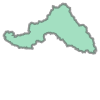

In [9]:
nodes=dict(n.nodes(data=True))

shape=sl.geometry.shape(nodes['5643001']['feature']['geometry'])
shape

In [10]:
def get_wh(geom):
    bounds = geom.bounds

    w = bounds[2]-bounds[0]
    h = bounds[3]-bounds[1]
    
    return (w, h) 
    
(w, h) = get_wh(shape)

print('w', w)
print('h', h)

('w', 2.4458333333333258)
('h', 1.3172339545355882)


In [11]:
def geometry_larger_than(geom, w, h):
    bounds = geom.bounds
    gw = bounds[2]-bounds[0]
    gh = bounds[3]-bounds[1]
    return (gw > w) or (gh > h)

def geometry_smaller_than(geom, w, h):
    bounds = geom.bounds
    gw = bounds[2]-bounds[0]
    gh = bounds[3]-bounds[1]
    return (gw < w) and (gh < h)

def get_leaves_smaller_than(node, w, h):
    for child_node in n.successors(node):
        geom = sl.geometry.shape(nodes[child_node]['feature']['geometry'])
        
        last = len(n.successors(child_node)) == 0
    
        if(geometry_smaller_than(geom, w, h) or last):
            yield child_node
        else:
            for child_child_node in get_leaves_smaller_than(child_node, w, h):
                yield child_child_node


In [65]:
max_w = 2.0
max_h = 2.0

In [66]:
leaves = list(get_leaves_smaller_than('564', max_w, max_h))
print(len(leaves))
s = n.subgraph(leaves)

469


In [53]:
basins_wh = []
basins_wh_min = []
basins_wh_max = []
basins_count = []


for basins in basins_per_level:
    whs = [get_wh(sl.geometry.shape(basin['geometry'])) for basin in basins]
    max_wh = np.max([max(whi) for whi in whs])
    min_wh = np.min([min(whi) for whi in whs])
    count = len(basins)
    wh = 0.5*(max_wh+min_wh)
    basins_wh_min.append(min_wh)
    basins_wh_max.append(max_wh)
    basins_wh.append(wh)
    basins_count.append(count)
    print(min_wh, wh, max_wh, count)

(1.4041666666666401, 5.3000028822156935, 9.1958390977647468, 10)
(0.021097988552526203, 3.0334685431586337, 6.0458390977647412, 27)
(0.021097988552526203, 2.4917989942762677, 4.9625000000000092, 137)
(0.0041666666666628771, 1.7315336439344549, 3.4589006212022468, 434)
(0.0041666666666628771, 1.1895833333333314, 2.375, 1439)
(0.0041666666666628771, 0.75236697726779944, 1.500567287868936, 3809)


In [59]:
# show number of catchments per level + maximum Width / Height
min_wh_values = []
max_wh_values = []
wh_values = []
average_wh_values = []
catchment_count = []
for i in np.arange(0.2, 9.0, 0.2):
    selection = list(get_leaves_smaller_than('564', i, i))
    
    wh = [get_wh(sl.geometry.shape(nodes[basin]['feature']['geometry'])) for basin in selection]
    max_wh = np.max([max(whi) for whi in wh])
    min_wh = np.min([min(whi) for whi in wh])
    average_wh_values.append(0.5*(min_wh+max_wh))
    count = len(basins)

    count = len(selection)
    print(min_wh, i, max_wh, count)
    catchment_count.append(count)
    max_wh_values.append(max_wh)
    min_wh_values.append(min_wh)
    
    wh_values.append(i)

(0.0041666666666628771, 0.20000000000000001, 2.375, 1439)
(0.0041666666666628771, 0.40000000000000002, 2.375, 1439)
(0.0041666666666628771, 0.60000000000000009, 2.375, 1439)
(0.0041666666666628771, 0.80000000000000004, 2.375, 1402)
(0.0041666666666628771, 1.0, 2.375, 1180)
(0.0041666666666628771, 1.2, 2.375, 1013)
(0.0041666666666628771, 1.4000000000000001, 2.375, 796)
(0.0041666666666628771, 1.6000000000000001, 2.375, 672)
(0.0041666666666628771, 1.8, 2.375, 546)
(0.0041666666666628771, 2.0, 2.375, 469)
(0.0041666666666628771, 2.2000000000000002, 2.375, 411)
(0.0041666666666628771, 2.4000000000000004, 2.375, 346)
(0.0041666666666628771, 2.6000000000000005, 2.5256442599826414, 305)
(0.0041666666666628771, 2.8000000000000003, 2.7203645494249145, 272)
(0.0041666666666628771, 3.0000000000000004, 2.9875000000000114, 222)
(0.0041666666666628771, 3.2000000000000002, 3.1883319430881158, 173)
(0.0041666666666628771, 3.4000000000000004, 3.2166666666666757, 165)
(0.0041666666666628771, 3.6000000

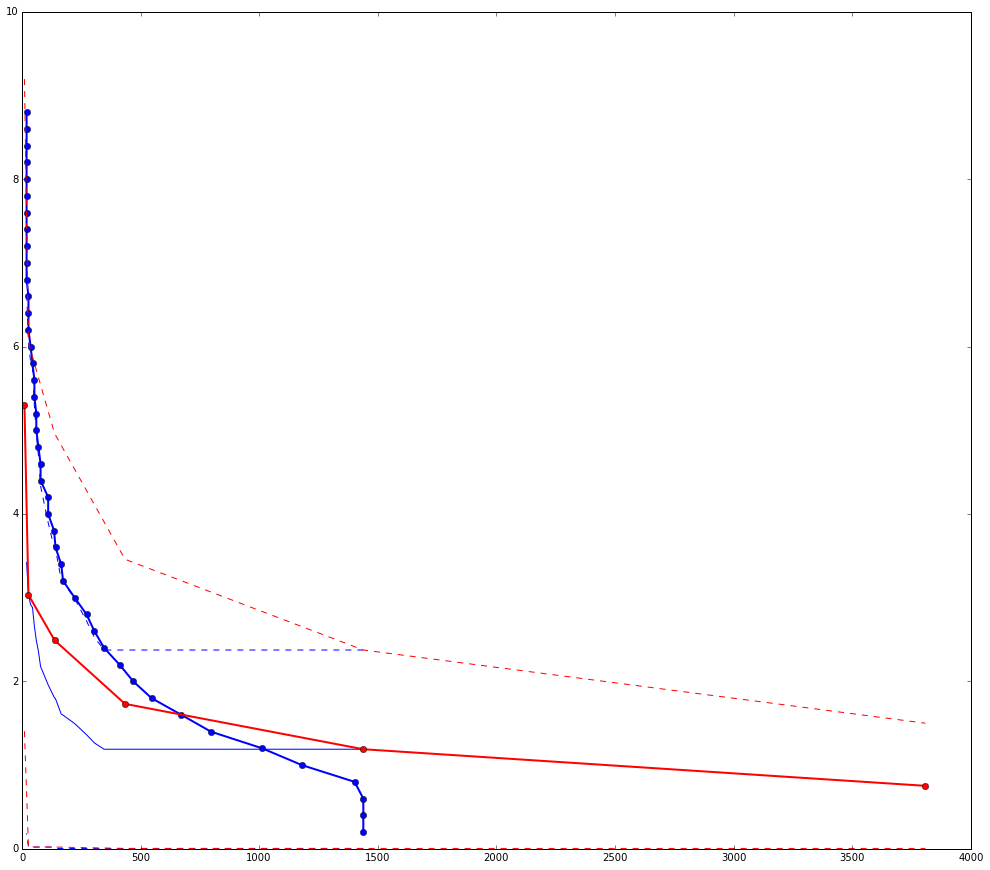

In [60]:
plt.plot(catchment_count, wh_values, 'ob-', linewidth=2.0)
plt.plot(catchment_count, average_wh_values, 'b-')
plt.plot(catchment_count, min_wh_values, 'b--')
plt.plot(catchment_count, max_wh_values, 'b--')


# plt.errorbar(wh_values, catchment_count,xerr=[min_error_wh_values, max_error_wh_values], fmt='.')


# plt.errorbar(wh_values, catchment_count, xerr=error_wh_values)

plt.plot(basins_count, basins_wh, 'or-', linewidth=2.0)
plt.plot(basins_count, basins_wh_min, 'r--')
plt.plot(basins_count, basins_wh_max, 'r--')

# plt.errorbar(basins_wh, basins_count, xerr=[basins_wh_error_min,basins_wh_error_max])


In [198]:
large_nodes = list((node for (node, data) in n.nodes(data=True) 
                    if geometry_larger_than(sl.geometry.shape(data['feature']['geometry']), max_w, max_h)))
s = n.subgraph(large_nodes)
print(len(large_nodes))
leaves=[node for node,data in s.out_degree().items() if data==0]
print(len(list(leaves)))
s = n.subgraph(leaves)


136


'5640017'

Try to open it in http://visjs.org/examples/network/15_dot_language_playground.html

In [14]:
nx.write_dot(n, r"..\output\catchment_pfafids.dot")
print(len(n.nodes()))

2048


In [69]:
pos = nx.spring_layout(nx.Graph(n), iterations=500)

C:\Anaconda\lib\site-packages\matplotlib\collections.py:764: RuntimeWarning: invalid value encountered in sqrt
  scale = np.sqrt(self._sizes) * dpi / 72.0 * self._factor


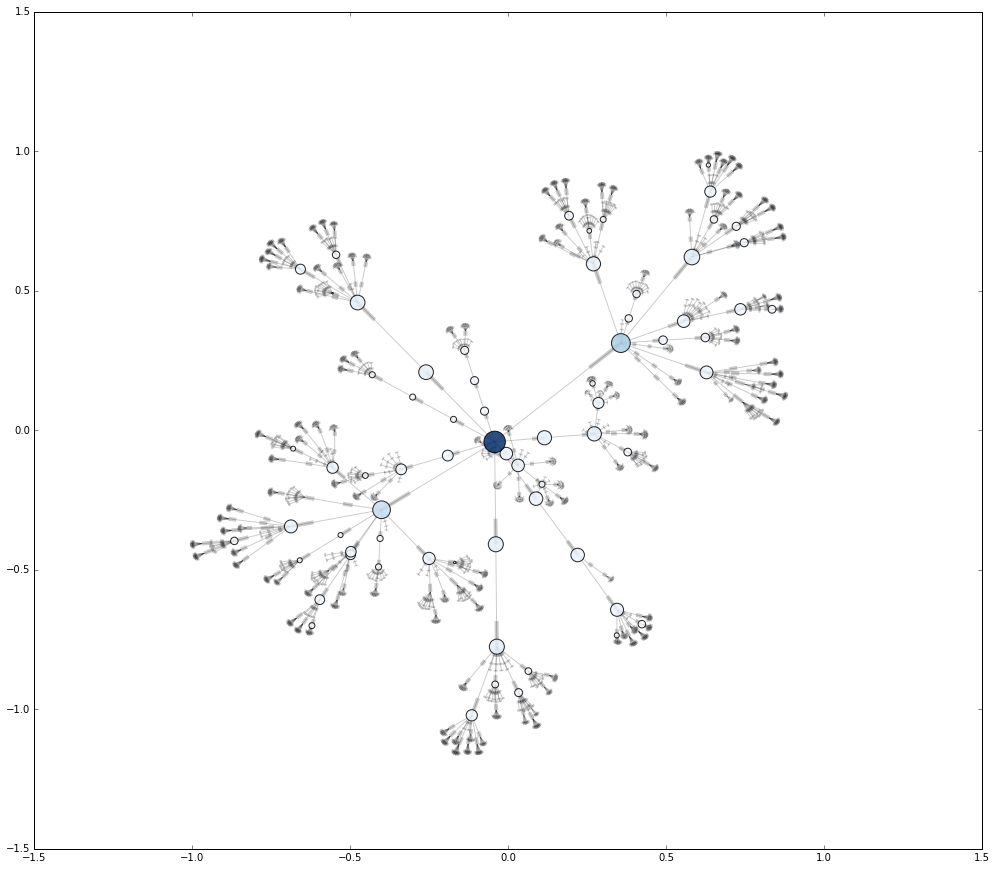

In [70]:
import math

node_areas=[data['area'] for node,data in n.nodes(data=True)]

node_sizes=[math.log(a)*100 for a in node_areas]

nx.draw_networkx_nodes(n, pos, node_color=node_areas, node_size=node_sizes, cmap=plt.cm.Blues, alpha=0.85)
_ = nx.draw_networkx_edges(n, pos, alpha=0.2)
# _ = nx.draw_networkx_labels(n, pos, font_size=15)

# nx.draw_networkx_nodes(s, pos, node_size=20, cmap=plt.cm.Reds, alpha=0.85)


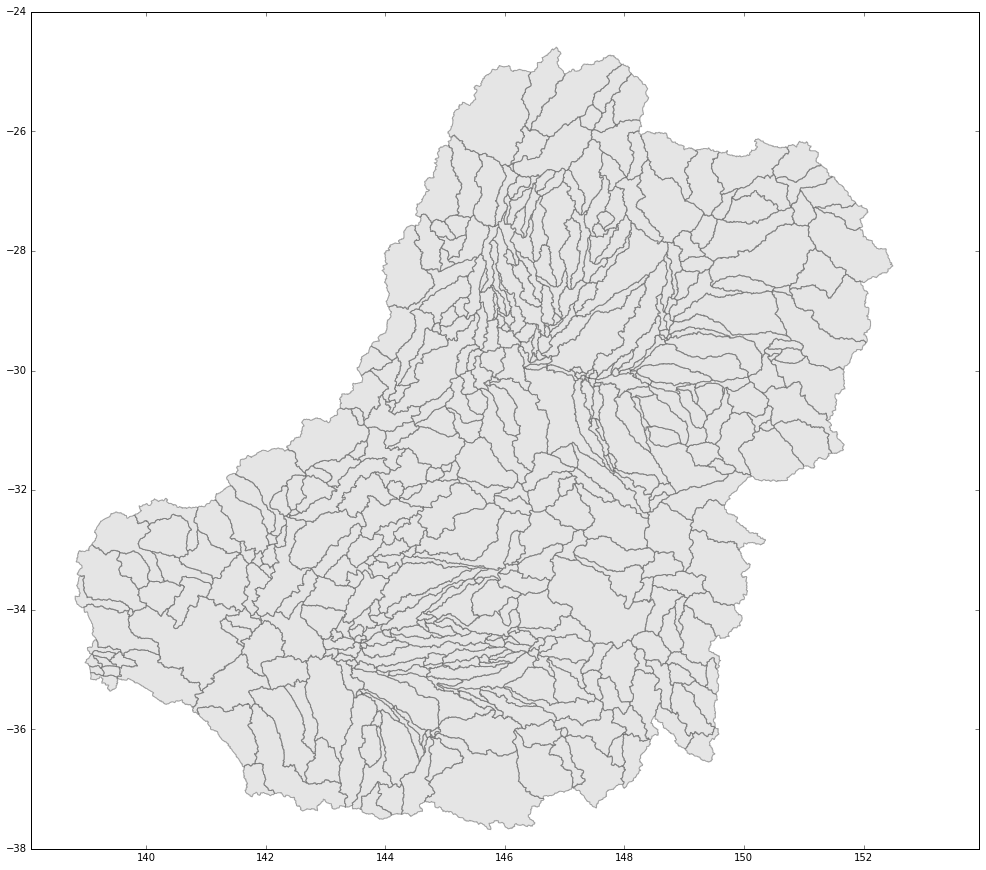

In [335]:
leaf_basins = list(s.nodes(data=True))

fig = plt.figure()
axes = plt.axes()
axes.set_aspect('equal', 'datalim')

for f in leaf_basins:
    geom = sl.geometry.shape(f[1]['feature']['geometry'])
    draw(geom, alpha=0.5)

plt.show()  


In [67]:
# write as a selection shp file

with fiona.open(files[2]) as source:
    source_driver = source.driver
    source_crs = source.crs
    source_schema = source.schema

# strange bug? values are not written unless we add .1
source_schema['properties']['HYBAS_ID'] = 'float:11.1'
source_schema['properties']['NEXT_DOWN'] = 'float:11.1'
source_schema['properties']['NEXT_SINK'] = 'float:11.1'
source_schema['properties']['MAIN_BAS'] = 'float:11.1'
print(source_schema)
    
with fiona.open('../output/small_basin_selection.shp', 'w', driver=source_driver, crs=source_crs, schema=source_schema) as c:
    for node in s.nodes(data=True):
        feature = node[1]['feature']
        c.write(feature)

{'geometry': 'Polygon', 'properties': OrderedDict([(u'HYBAS_ID', 'float:11.1'), (u'NEXT_DOWN', 'float:11.1'), (u'NEXT_SINK', 'float:11.1'), (u'MAIN_BAS', 'float:11.1'), (u'DIST_SINK', 'float:10.1'), (u'DIST_MAIN', 'float:10.1'), (u'SUB_AREA', 'float:10.1'), (u'UP_AREA', 'float:10.1'), (u'PFAF_ID', 'int:8'), (u'ENDO', 'int:6'), (u'COAST', 'int:6'), (u'ORDER', 'int:6'), (u'SORT', 'float:11')])}


['564']
['56428', '56429', '56420', '56421', '56422', '56423', '56424', '56425', '56426', '56427']


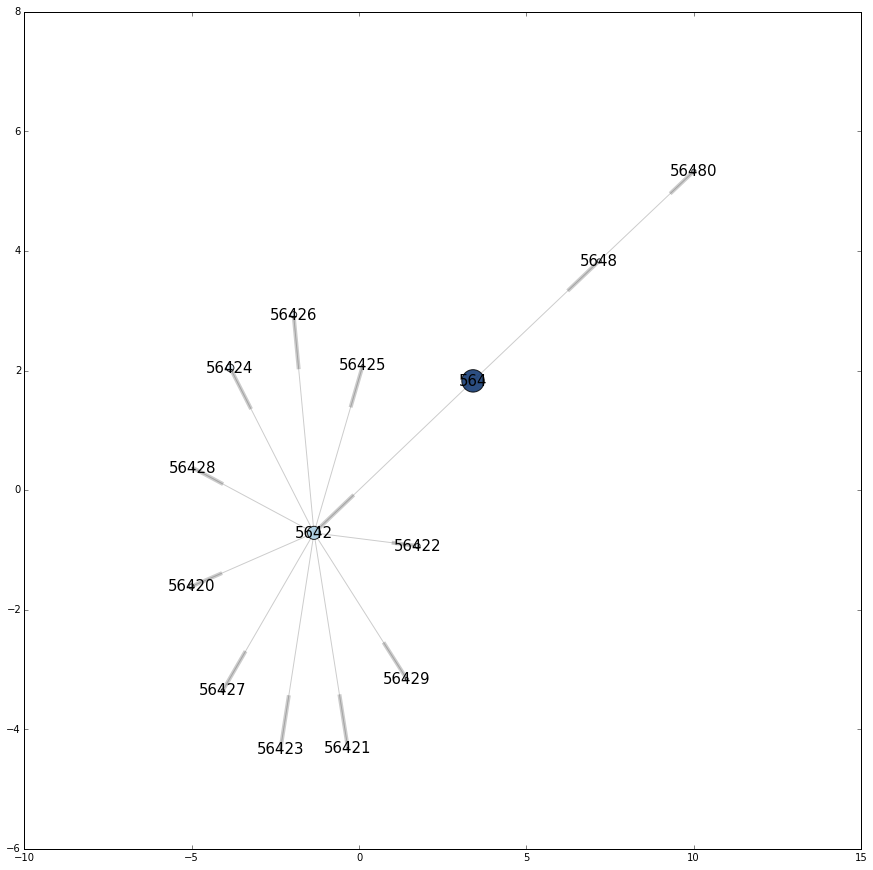

In [21]:
print(n.predecessors('5642'))
print(n.successors('5642'))

s = n.subgraph(n.successors('5642')+['5642','564','56424','5648','56480'])

node_areas=[data['area'] for node,data in s.nodes(data=True)]
node_sizes=[a*5 for a in node_areas]

pos = nx.spring_layout(nx.Graph(s), iterations=500, scale=10.0)

nx.draw_networkx_nodes(s, pos, node_color=node_areas, node_size=node_sizes, cmap=plt.cm.Blues, alpha=0.85)
_ = nx.draw_networkx_edges(s, pos, alpha=0.2)
_ = nx.draw_networkx_labels(s, pos, font_size=15)    

Select basins where Area + Width/Height ratio are just less than a given parameter

In [20]:
def get_catchments_using_area(graph, root, max_area):
    children = graph.successors(root)
    for child in children:
        graph[child]
    
print(n.predecessors('5642'))
print(n.successors('5642'))


['564']
['56428', '56429', '56420', '56421', '56422', '56423', '56424', '56425', '56426', '56427']
